In [17]:
import os
import tensorflow as tf
import numpy as np

SEED = 1234
tf.random.set_seed(SEED)  


In [6]:
# Run this cell only if you are using Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/data.zip"

In [18]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255)


In [14]:
!ls /content

data  drive  sample_data


In [19]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
# Get current working directory
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'data')

# img

# Batch size
bs = 8

# img shape
img_h = 256
img_w = 256

num_classes=3

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)



Found 5052 images belonging to 3 classes.
Found 562 images belonging to 3 classes.


In [21]:
train_gen.class_indices

{'class_0': 0, 'class_1': 1, 'class_2': 2}

In [20]:
# Create Dataset objects
# ----------------------
size = (256, 256)
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Shuffle (Already done in generator..)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_gen))

# Normalize images (Already done in generator..)
# def normalize_img(x_, y_):
#     return tf.cast(x_, tf.float32) / 255., y_

# train_dataset = train_dataset.map(normalize_img)

# 1-hot encoding <- for categorical cross entropy (Already done in generator..)
# def to_categorical(x_, y_):
#     return x_, tf.one_hot(y_, depth=10)

# train_dataset = train_dataset.map(to_categorical)

# Divide in batches (Already done in generator..)
# train_dataset = train_dataset.batch(bs)

# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
valid_dataset = valid_dataset.repeat()



In [18]:
test = train_dataset.take(1)
test

<TakeDataset shapes: ((None, 256, 256, 3), (None, 3)), types: (tf.float32, tf.float32)>

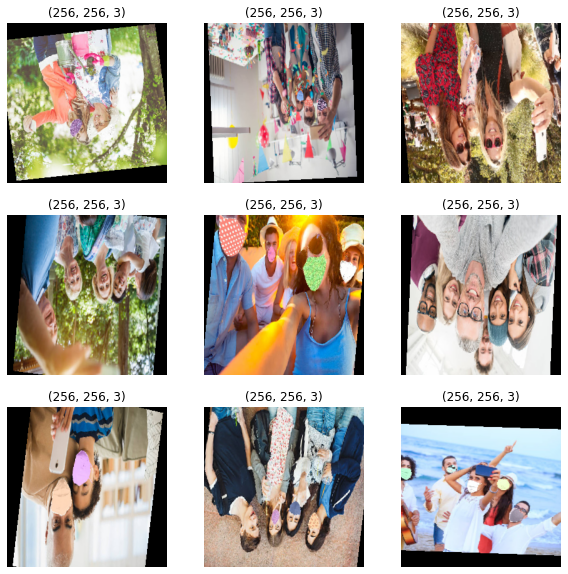

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(image[i].shape)
    plt.axis("off")

In [23]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [25]:
# Create Model
# ------------

finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False
    
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 31,493,955
Trainable params: 23,858,691
Non-trainable params: 7,635,264
_________________________________________________________________


[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
    

In [26]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

import os
from datetime import datetime



cwd = os.path.join(os.getcwd(),"logs")

exps_dir = os.path.join(cwd, 'transfer_learning_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

epochs = 17
model.fit(x=train_dataset, epochs=epochs,steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

Epoch 1/17
632/632 [==============================] - 139s 220ms/step - loss: 0.9094 - accuracy: 0.5443 - val_loss: 0.7033 - val_accuracy: 0.6673
Epoch 2/17
632/632 [==============================] - 139s 220ms/step - loss: 0.6959 - accuracy: 0.6681 - val_loss: 0.6352 - val_accuracy: 0.6833
Epoch 3/17
632/632 [==============================] - 138s 218ms/step - loss: 0.6406 - accuracy: 0.7057 - val_loss: 0.6214 - val_accuracy: 0.7260
Epoch 4/17
632/632 [==============================] - 140s 221ms/step - loss: 0.5782 - accuracy: 0.7361 - val_loss: 0.5318 - val_accuracy: 0.7544
Epoch 5/17
632/632 [==============================] - 138s 219ms/step - loss: 0.5201 - accuracy: 0.7625 - val_loss: 0.5165 - val_accuracy: 0.7651
Epoch 6/17
632/632 [==============================] - 137s 217ms/step - loss: 0.4810 - accuracy: 0.7894 - val_loss: 0.4422 - val_accuracy: 0.8043
Epoch 7/17
632/632 [==============================] - 138s 218ms/step - loss: 0.4464 - accuracy: 0.8007 - val_loss: 0.4820 -

In [27]:
model.save('/content/drive/My Drive/saved_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/saved_model/assets


In [26]:
model= tf.keras.models.load_model('saved_model')

In [ ]:
import pandas as pd
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')


test_dir = os.path.join(dataset_dir, 'test')

images = [f for f in os.listdir(test_dir)]
images = pd.DataFrame(images)
images.rename(columns = {0:'filename'}, inplace = True)
images["class"] = 'test'

test_gen = train_data_gen.flow_from_dataframe(images,
                                               test_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)


test_gen.reset()

predictions = model.predict(test_gen, len(test_gen), verbose=1)

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1

create_csv(results)

Found 450 validated image filenames belonging to 1 classes.
15/57 [======>.......................] - ETA: 55s